In [219]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
# misc
import datetime as dt
from pprint import pprint
from itertools import chain
# reddit crawler
import praw
import os
from praw.models import MoreComments


# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
from dotenv import load_dotenv

The credentials for using the Praw - Python Reddit API Wrapper are stored on the local system and the environment is loaded into this notebook to maintain the security of the credentials. 

In [183]:
load_dotenv(override=True)
reddit_client_id = os.environ.get('REDDIT_CLIENT_ID')
reddit_client_secret = os.environ.get('REDDIT_CLIENT_SECRET')
reddit_user_agent = os.environ.get('REDDIT_USER_AGENT')


In [184]:
r = praw.Reddit(user_agent=reddit_user_agent,
                client_id=reddit_client_id,
                client_secret=reddit_client_secret,
                check_for_async=False)

The function fetch_top fetches the top posts of all time given a subreddit name.

In [276]:
def fetch_top(subreddit_name):
    subreddit_fetch = r.subreddit(subreddit_name)
    
    top_posts = [*subreddit_fetch.top(time_filter='all')] # top posts all time
    
    return top_posts

In [277]:
top_posts_tech = fetch_top('technology')

create_data_frame() creates a dataframe including the different parts in a reddit post such as headlines, upvotes, timestamps, etc

In [188]:
def create_data_frame(posts):
    # Initialize lists to store data
    headlines = []
    upvotes = []
    timestamps = []
    dates = []
    num_comments = []
    upvote_ratios = []
    awards_received = []
    
    for post in posts:
        headlines.append(post.title)
        upvotes.append(post.score)
        timestamps.append(post.created)
        dates.append(dt.datetime.fromtimestamp(post.created))
        num_comments.append(post.num_comments)
        upvote_ratios.append(post.upvote_ratio)
        awards_received.append(post.total_awards_received)
        
    
    # Create DataFrame
    data = {
        'Headline': headlines,
        'Upvotes': upvotes,
        'Timestamp': timestamps,
        'Date': dates,
        'Num_Comments': num_comments,
        'Upvote_Ratio': upvote_ratios,
        'Awards_Received': awards_received
    }
    
    posts_as_df = pd.DataFrame(data)
    return posts_as_df

In [279]:
top_posts_tech_df = create_data_frame(top_posts_tech)

In splitting_data_frame , we try to split the dataframe based on its posted date into three categories : pre-2019, 2019-2022, post 2022. We chose the timeframes to be as such so that we can analyze the sentiment of the posts pre COVID, post covid and the begin of tech layoffs season.

In [190]:
def splitting_data_frame(df):
    df_copy = df.copy()
    
    # Create subsets based on date conditions using the copied DataFrame
    before_2019 = df_copy[df_copy['Date'] < dt.datetime(2019, 1, 1)]
    between_2019_2022 = df_copy[(df_copy['Date'] >= dt.datetime(2019, 1, 1)) & (df_copy['Date'] < dt.datetime(2023, 1, 1))]
    post_2022 = df_copy[df_copy['Date'] >= dt.datetime(2023, 1, 1)]
    return before_2019,between_2019_2022,post_2022

In [280]:
before_2019,between_2019_2022,post_2022 = splitting_data_frame(top_posts_tech_df)

define_sid() defines a sentiment analyzer that uses VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. We also show how the analyzer behaves given the below three strings. We observe that this analyzer can correctly classify strings as positive, negative or neutral

In [192]:
def define_sid():
    sid = SentimentIntensityAnalyzer()
    
    neutral_text = "General information about the company"
    pos_text = "Company did amazingly well in this quarter" # captilization and ! increases the effect
    neg_text = "Layoffs and people were fired or resigned"
    
    print(sid.polarity_scores(neutral_text))
    print(sid.polarity_scores(pos_text))
    print(sid.polarity_scores(neg_text))
    return sid


In [193]:
sid = define_sid()

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.3384}
{'neg': 0.528, 'neu': 0.472, 'pos': 0.0, 'compound': -0.6808}


The get_sentiment_score() evaluates the text and returns the polarity score for the text. sentiment_score_df() function passes the headline to the get_sentiment_score() and adds the score to the dataframe as 'Sentiment_Scores'.

In [194]:
def get_sentiment_score(text):
    return sid.polarity_scores(text)

In [195]:
def sentiment_score_df(df):
    df.loc[:, 'Sentiment_Scores'] = df['Headline'].apply(lambda x: get_sentiment_score(x))
    return df

For each of the year range, we find the sentiment score for each of the headline of the posts collected.

In [281]:
before_2019 = sentiment_score_df(before_2019)
between_2019_2022 = sentiment_score_df(between_2019_2022)
post_2022 = sentiment_score_df(post_2022)

get_compound_sentiment() compounds the sentiment scores and grades it as Positive, Negative and Neutral.

In [197]:
def get_compund_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

For each of the year range, we find the compounded sentiment score for each of the headline of the posts collected.

In [198]:
def compund_score_df(df):
    df.loc[:, 'Sentiment'] = df['Headline'].apply(lambda x: get_compund_sentiment(x))
    return df

In [282]:
before_2019 = compund_score_df(before_2019)
between_2019_2022 = compund_score_df(between_2019_2022)
post_2022 = compund_score_df(post_2022)

The number of articles in each of the DataFrame before_2019,between_2019_2022 and post_2022 vary which can affect the sentiment analysis. By normalizing the sentiment scores, we can obtain a good representation of the sentiment distribution within each DataFrame, regardless of the total number of articles.

In [200]:
def temp_normalize_sentiment(df):
    # Calculate the percentage of positive, negative, and neutral articles relative to the total number of articles
    df_sentiment_counts = df['Sentiment'].value_counts()
    return df_sentiment_counts

In [201]:
def normalize_sentiment(df):
    # Calculate the percentage of positive, negative, and neutral articles relative to the total number of articles
    df_sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100
    return df_sentiment_counts

In [283]:
print("Before 2019 Sentiment Distribution:")
before_2019_normalized = normalize_sentiment(before_2019)
print(before_2019_normalized)

print("\nBetween 2019 and 2022 Sentiment Distribution:")
between_2019_2022_normalized = normalize_sentiment(between_2019_2022)
print(between_2019_2022_normalized)

print("\nPost 2022 Sentiment Distribution:")
post_2022_normalized = normalize_sentiment(post_2022)
print(post_2022_normalized)

Before 2019 Sentiment Distribution:
Sentiment
Negative    60.606061
Positive    24.242424
Neutral     15.151515
Name: proportion, dtype: float64

Between 2019 and 2022 Sentiment Distribution:
Sentiment
Negative    55.172414
Positive    24.137931
Neutral     20.689655
Name: proportion, dtype: float64

Post 2022 Sentiment Distribution:
Sentiment
Negative    77.777778
Neutral     11.111111
Positive    11.111111
Name: proportion, dtype: float64


Using the data we have obtained, we display a histogram showing the different sentiments across the years.

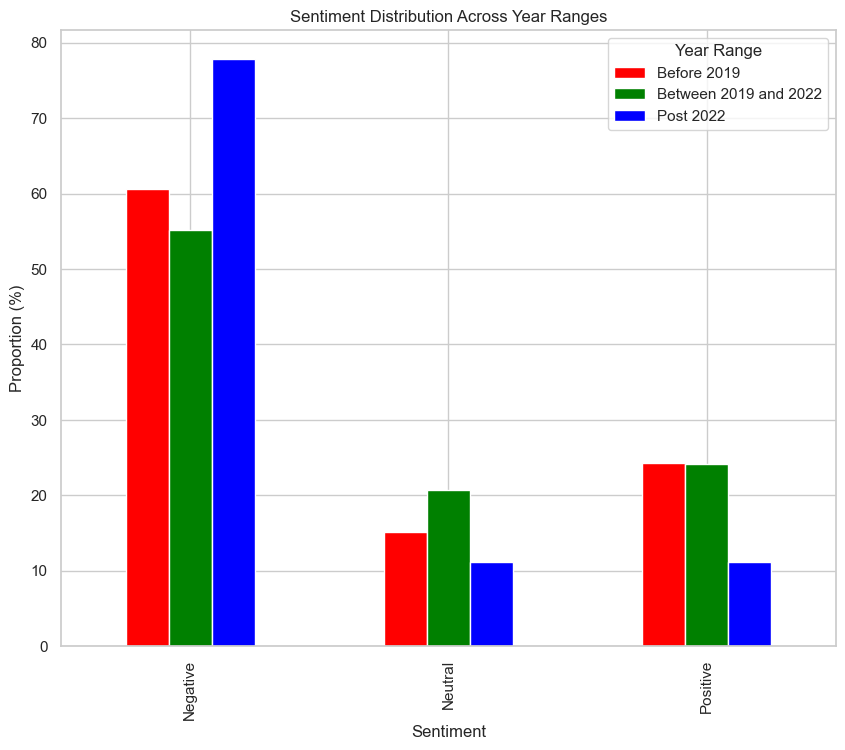

In [284]:
# Combine all sentiment proportions into one DataFrame
combined_sentiments = pd.DataFrame({
    'Before 2019': before_2019_normalized,
    'Between 2019 and 2022': between_2019_2022_normalized,
    'Post 2022': post_2022_normalized
})

# Plot a grouped bar chart for all sentiments
combined_sentiments.plot(kind='bar', color=['red', 'green', 'blue'])

# Add labels and title
plt.title('Sentiment Distribution Across Year Ranges')
plt.xlabel('Sentiment')
plt.ylabel('Proportion (%)')

# Show the plot
plt.legend(title='Year Range')
plt.show()


Using the data we have obtained, we display a scatterplot showing the impact of upvote ratios and how sentiment varies as per it.

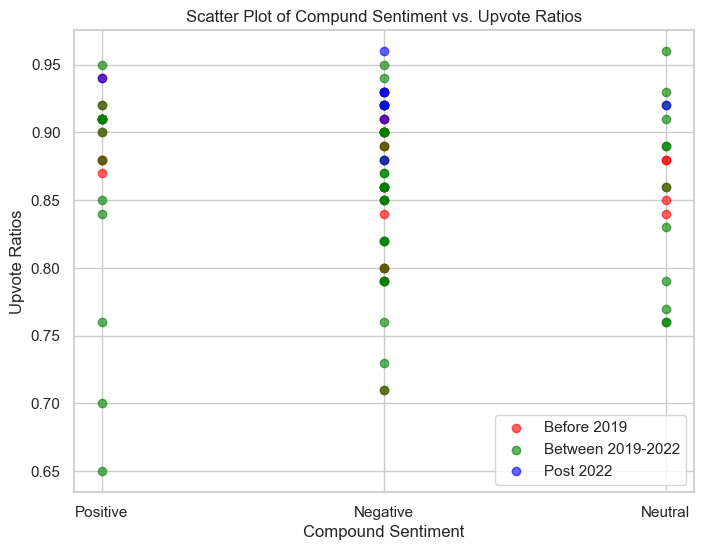

In [299]:
sentiment_scores = before_2019['Sentiment']
sentiment_scores = sentiment_scores.tolist() # upvote_ratio = before_2019['Upvote_Ratio']

upvote_ratios = before_2019['Upvote_Ratio']
upvote_ratios = upvote_ratios.tolist()
sentiment_scores_between = between_2019_2022['Sentiment'].tolist()
upvote_ratios_between = between_2019_2022['Upvote_Ratio'].tolist()

# Extract sentiment scores and upvote ratios from post_2022 dataframe
sentiment_scores_post = post_2022['Sentiment'].tolist()
upvote_ratios_post = post_2022['Upvote_Ratio'].tolist()

# Plot all data on the same scatter plot
plt.figure(figsize=(8, 6))

# Plot data from before_2019 dataframe
plt.scatter(sentiment_scores, upvote_ratios, color='red', alpha=0.6, label='Before 2019')

# Plot data from between_2019_2022 dataframe
plt.scatter(sentiment_scores_between, upvote_ratios_between, color='green', alpha=0.6, label='Between 2019-2022')

# Plot data from post_2022 dataframe
plt.scatter(sentiment_scores_post, upvote_ratios_post, color='blue', alpha=0.6, label='Post 2022')

plt.xlabel('Compound Sentiment')
plt.ylabel('Upvote Ratios')
plt.title('Scatter Plot of Compund Sentiment vs. Upvote Ratios')
plt.legend()
plt.grid(True)
plt.show()

Lastly, we construct a heatmap to see if the number of comments on each post has an impact on the sentiment of the post.

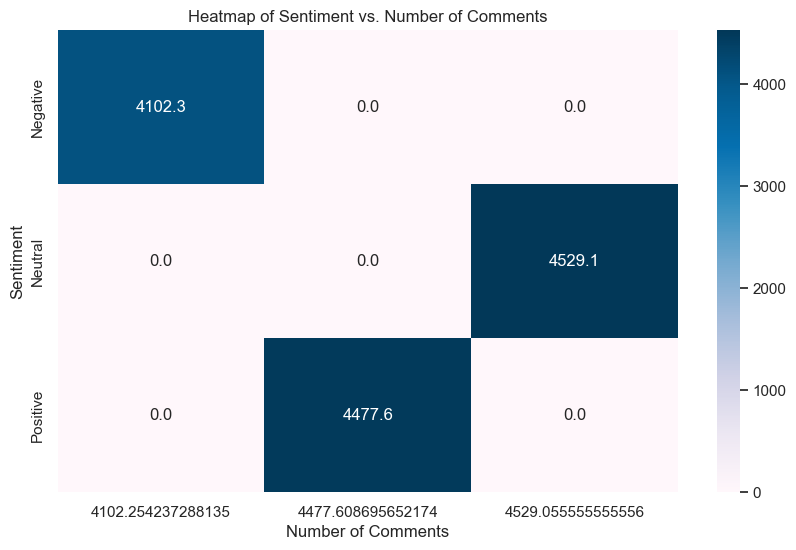

In [288]:
# Aggregate data from all three dataframes
heatmap_data_all = pd.concat([before_2019, between_2019_2022, post_2022])
# Group by 'Sentiment' and calculate the mean of 'Num_Comments'
heatmap_data_all = heatmap_data_all.groupby('Sentiment')['Num_Comments'].mean().reset_index()

# Pivot the data for heatmap
heatmap_matrix_all = heatmap_data_all.pivot(index='Sentiment', columns='Num_Comments', values='Num_Comments').fillna(0)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix_all, cmap='PuBu', annot=True, fmt='.1f')
plt.title('Heatmap of Sentiment vs. Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Sentiment')
plt.show()